# Experiment 1.5.1
Here we take a slight step back and simplify the test images to be a single dot. The size and position of the dot will be varied.

In [1]:
import cv2
import numpy as np
from enum import Enum
import colorsys
import moviepy.editor as mpe
import moviepy
from typing import *
import random
import pandas as pd
import json
import torch
from icecream import ic
import nncolor as nc
import nncolor.data
import torchinfo
import torchvision as tv
import torchvision.datasets
import itertools
import torchvision.models
import torchvision.transforms
import torch.nn
import torch.optim
import time
import copy
import os
import torch.hub
from collections import namedtuple
import ipyplot
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
import IPython
def imshow(img):
    """Show image. 
    
    Image is a HWC numpy array with values in the range 0-1."""
    img = img*255
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # cv2 imencode takes images in HWC dimension order.
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i) 
    
    
def imlist(images, labels=None, use_tabs=False):
    if md_export_mode:
        print("Skipping ipyplot image print for markdown export. The output"
              " produces HTML that either Jupyter Lab fails to export correctly,"
              " or Hugo fails to render correctly. Skipping for now.")
        return
    if use_tabs:
        ipyplot.plot_class_tabs(images, labels, max_imgs_per_tab=300)
    else:
        ipyplot.plot_images(images, labels)

## 1. Notebook constants
Variables used as constants throughout the notebook.

In [3]:
# Choose CPU or GPU.
device = torch.device('cuda:1')
#device = "cpu"

# Choose small or large (standard) model variant
model_name = "resnet18"
#model_name = 'resnet50'
def model_fctn():
    if model_name == 'resnet18':
        return tv.models.resnet18(pretrained=True)
    elif model_name == 'resnet50':
        return tv.models.resnet50(pretrained=True)
resnet_model = model_fctn()

IMG_SHAPE = (224, 224, 3)
BATCH_SIZE = 4
NUM_EPOCHS = 20
NUM_FC_CHANNELS = 512 if model_name == 'resnet18' else 2048

In [4]:
GRID_SHAPE = (1, 1)
CENTER_ACTIVATION = 0 # position (1, 1) in grid of 1x1
NUM_CELLS = 1
cell_shape = nc.data.cell_shape(GRID_SHAPE, IMG_SHAPE)
assert np.array_equal(cell_shape, IMG_SHAPE[0:-1])

## 2. Dataset
Inspect some of the images. 
Four images are shown below:

 1. using the smallest radius
 2. using a mid-sized radius
 3. using a radius just small enough to glimpse a background.
 4. using the largest radius

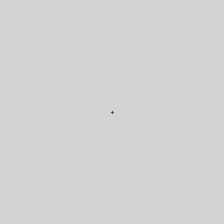

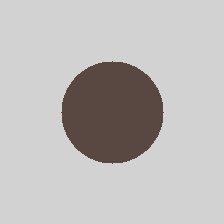

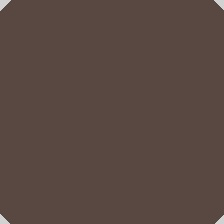

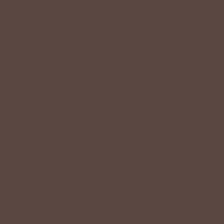

In [5]:
radii =  radii = [1, 51, 151, 166]
for r in radii:
    train_ds, _, _ = nc.data.train_test_val_split(nc.data.exp_1_1_data_filtered,
                                                  dot_radius=r,
                                                  grid_shape=GRID_SHAPE)
    imshow(train_ds[6]['image'])
    

In [22]:
# Data augmentation and normalization
normalize_transform =  tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
to_CHW_tensor_transform = tv.transforms.ToTensor()
data_transform = tv.transforms.Compose([to_CHW_tensor_transform, normalize_transform])
# 112 / 8 = 14
offsets = list(range(0, 112+1, 8))
# Varations, by dot radius.
# 168 / 6 = 28. So 28 dot sizes, increasing by 6 pixels. For the first sample, we use 
# 1 instead of 0.
radii = [1,] + list(range(6, 168 + 1, 6))

In [11]:
def datasplits_by_pos_and_radius():
    # Data
    color_data = nc.data.exp_1_1_combined_data
    color_data = color_data[color_data['ans'] != nc.data.LABEL_TO_COLOR_ID['both']]
    color_data = nc.data.deserialize(color_data)
    def train_test_val(offset, radius):
        train_ds, test_ds, val_ds = nc.data.train_test_val_split(color_data,
                                                                dot_radius=radius,
                                                                grid_shape=GRID_SHAPE,
                                                                dot_offset=(offset, offset))
        DataSplit = namedtuple('DataSplit', ['ds', 'loader', 'size'])
        splits = {
            'train': DataSplit(train_ds, torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=4), len(train_ds)),
            'test':  DataSplit(test_ds,  torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=4), len(test_ds)),
            'val':   DataSplit(val_ds,   torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=4), len(val_ds))
        }
        splits['val'].ds.transform = data_transform
        splits['train'].ds.transform = data_transform
        splits['test'].ds.transform = to_CHW_tensor_transform
        return splits
    datasplits = {(o,r): train_test_val(o, r) for (o,r) in itertools.product(offsets, radii)}
    return datasplits 
datasplits = datasplits_by_pos_and_radius()

In [18]:
## 3. Model
def tweaked_model():
    model = model_fctn()
    for param in model.parameters():
        param.requires_grad = False
    # We do still have training parameters:
    num_features = model.fc.in_features
    model.fc = torch.nn.Linear(num_features, 4)
    return model

## 3. Training

In [ ]:
def train_new_model(datasplit):
    model = tweaked_model()
    model = model.to(device)
    # Observe that all parameters are being optimized
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # Decay LR by a factor of 0.1 every 7 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(NUM_EPOCHS):
        print('Epoch {}/{}'.format(epoch, NUM_EPOCHS - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for batch in datasplit[phase].loader:
                inputs = batch['image'].to(device)
                labels = batch['label'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = torch.nn.functional.cross_entropy(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            denom = datasplit[phase].size
            epoch_loss = running_loss / denom
            epoch_acc = running_corrects.double() / denom
            # To verbose.
            #print('{} Loss: {:.5f} Acc: {:.5f}'.format(
            #    phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())            
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return best_model_wts

save_path = f'./resources/exp_1_5_1/{model_name}_radius_{radius}_offset_{offset}_save'
for (offset, radius), datasplit in datasplits.items():
    print(f'Training start. Offset {offset}, radius {radius}')
    best_model_wts = train_new_model(datasplit)
    torch.save(best_model_wts, save_path.format(model=model_name, radius=r))

Training start. Offset 0, radius 1
Epoch 0/19
----------
train Loss: 0.97415 Acc: 0.61314
val Loss: 0.98678 Acc: 0.62195

Epoch 1/19
----------
train Loss: 0.86017 Acc: 0.67640
val Loss: 1.06338 Acc: 0.63415

Epoch 2/19
----------
train Loss: 0.82989 Acc: 0.68856
val Loss: 1.03561 Acc: 0.64634

Epoch 3/19
----------
train Loss: 0.80203 Acc: 0.69951
val Loss: 0.99213 Acc: 0.64024

Epoch 4/19
----------
train Loss: 0.77659 Acc: 0.70195
val Loss: 0.95470 Acc: 0.63415

Epoch 5/19
----------
train Loss: 0.75337 Acc: 0.71046
val Loss: 0.92520 Acc: 0.63415

Epoch 6/19
----------
train Loss: 0.73212 Acc: 0.71533
val Loss: 0.90257 Acc: 0.63415

Epoch 7/19
----------
train Loss: 0.55962 Acc: 0.79319
val Loss: 0.81041 Acc: 0.68293

Epoch 8/19
----------
train Loss: 0.50228 Acc: 0.79805
val Loss: 0.80033 Acc: 0.66463

Epoch 9/19
----------
train Loss: 0.49662 Acc: 0.80414
val Loss: 0.79324 Acc: 0.66463

Epoch 10/19
----------
train Loss: 0.49274 Acc: 0.80535
val Loss: 0.78793 Acc: 0.66463

Epoch 1

## 7. Investigate model
To explore the nature of the predictions, I want an array with dimensions (label, prediction) and values are tallies. Accuracy for each label is then the diagonal divided by the sum along the prediction dimension. Overall accuracy is the sum along the diagonal divided by the complete sum. 

In [20]:
acc = {}
def inspect(): 
    for (offset, radius), datasplit in datasplits.items():
        model = tweaked_model().to(device)
        model.load_state_dict(torch.load(save_path.format(model_name=model_name, 
                                                          radius=radius,
                                                          offset=offset)))
        corrects = 0
        for batch in datasplit['test'].loader:
            images = batch['image']
            inputs = normalize_transform(images).to(device)
            labels = batch['label'].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
        acc[(offset, radius)] = corrects / datasplit['test'].size
inspect()

0.47154468297958374 0.7459349036216736


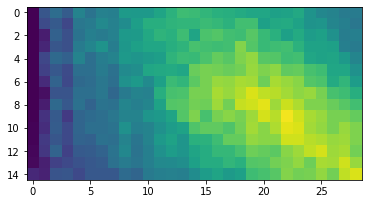

In [30]:
def display_data():
    arr = np.zeros((len(offsets), len(radii)))
    xlabels = offsets
    ylabels = radii
    for odx, o in enumerate(offsets):
        for rdx, r in enumerate(radii):
            arr[odx, rdx] = acc[(o, r)]
    fig, ax = plt.subplots()
    ax.imshow(arr, cmap='viridis', vmin=0.5, vmax=0.75)
    print(np.min(arr), np.max(arr))
display_data()    